In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import requests, zipfile, io
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [20]:
# Load datasets
store_info = pd.read_csv("https://raw.githubusercontent.com/maddawg9838/dataset/refs/heads/main/store.csv")

# Download zip file and open to read train_data
zip_url = "https://github.com/maddawg9838/dataset/raw/refs/heads/main/train.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
train_data = pd.read_csv(z.open("train.csv"))

/tmp/ipython-input-1225357277.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(z.open("train.csv"))


In [21]:
store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [22]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [23]:
# Merge the store info dataset with the train dataset based on Store
data = pd.merge(train_data, store_info, on="Store", how="left")

# Exploratory Data Analysis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [24]:
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [25]:
# Check for missing values
missing = data.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

# Fill missing categorical features with 'None'
data.fillna({'PromoInterval':'None'}, inplace=True)

# Fill in numerical features using 0
data.fillna(0, inplace=True)

Promo2SinceWeek              508031
PromoInterval                508031
Promo2SinceYear              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
dtype: int64


In [26]:
# Convert and extract time-based features
data["Date"] = pd.to_datetime(data["Date"])
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["WeekOfYear"] = data["Date"].dt.isocalendar().week
data["DayOfWeek"] = data["Date"].dt.dayofweek

In [27]:
# Encode Categorical Features
categorical_features = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
data = pd.get_dummies(data, columns=categorical_features, drop_first=False)

In [28]:
# Filter for only open stores
data = data[data["Open"] != 0]

# Check size of data after filtering
data.shape

(844392, 34)

In [29]:
# Helper function to sample the data set and keep same distributoin
def stratified_sample(df, frac=0.30):
    df = df.copy()

    # Extract month for stratification
    df["Month"] = df["Date"].dt.month

    # Reconstruct categorical StoreTypeLabel
    storetype_cols = [c for c in df.columns if c.startswith("StoreType_")]
    df["StoreTypeLabel"] = df[storetype_cols].idxmax(axis=1).fillna("StoreType_a")

    # Build stratification column
    df["Stratum"] = (
        df["StoreTypeLabel"].astype(str)
        + "_M" + df["Month"].astype(str)
        + "_D" + df["DayOfWeek"].astype(str)
    )

    # Stratified sampling using groupby.sample
    sampled_data = df.groupby("Stratum", group_keys=False).sample(frac=frac, random_state=42)

    # Drop temporary columns
    sampled_data = sampled_data.drop(columns=["Stratum", "StoreTypeLabel"])

    return sampled_data

In [30]:
# Check for duplicates in the data
duplicates = data.columns[data.columns.duplicated()]
print(duplicates)

# Drop duplicates
data = data.drop(columns=duplicates)

# Sort data
data = data.sort_values(['Store', 'Date'])

# Apply stratified sampling
sampled_data = stratified_sample(data, frac=0.30)

print("Original size:", data.shape)
print("Sampled size:", sampled_data.shape)

Index(['StateHoliday_0'], dtype='object')
Original size: (844392, 32)
Sampled size: (253319, 32)


In [31]:
# Label based on store type for Local LSTMs
storetype_cols = [c for c in sampled_data.columns if c.startswith("StoreType_")]
labeled_data = sampled_data.copy()
labeled_data["StoreTypeLabel"] = sampled_data[storetype_cols].idxmax(axis=1).fillna("StoreType_a")

In [32]:
# Define date-based split for Global forecasting
train_end = "2014-12-31"
validation_end = "2015-06-30"

# Split into train, validation, and test datasets
train_df = sampled_data[sampled_data["Date"] <= train_end]
validation_df = sampled_data[(sampled_data["Date"] > train_end) & (sampled_data["Date"] <= validation_end)]
test_df = sampled_data[sampled_data["Date"] > validation_end]

# Create scaler
global_scaler = MinMaxScaler()

# Fit scalar onto Sales
global_scaler.fit(train_df[['Sales']])

# Make explicit copies to avoid SettingWithCopyWarning
train_df = train_df.copy()
validation_df = validation_df.copy()
test_df = test_df.copy()

# Add scaled sales as a new column
train_df.loc[:, 'Sales_scaled'] = global_scaler.transform(train_df[['Sales']])
validation_df.loc[:, 'Sales_scaled'] = global_scaler.transform(validation_df[['Sales']])
test_df.loc[:, 'Sales_scaled'] = global_scaler.transform(test_df[['Sales']])

# Check shapes of each dataset
print("Train Data:", train_df.shape)
print("Validation Data:", validation_df.shape)
print("Test Data:", test_df.shape)

Train Data: (194635, 33)
Validation Data: (49666, 33)
Test Data: (9018, 33)


In [33]:
# Build local datasets grouped by StoreTypeLabel using data_with_label
local_sets = {}
store_types = labeled_data['StoreTypeLabel'].unique()

for store in store_types:
    # get rows corresponding to this store type and then limit by date split ranges
    train_local = labeled_data[(labeled_data['StoreTypeLabel']==store) & (labeled_data['Date'] <= train_end)][['Store','Date','Sales']].copy()
    validation_local   = labeled_data[(labeled_data['StoreTypeLabel']==store) & (labeled_data['Date'] > train_end) & (labeled_data['Date'] <= validation_end)][['Store','Date','Sales']].copy()
    test_local  = labeled_data[(labeled_data['StoreTypeLabel']==store) & (labeled_data['Date'] > validation_end)][['Store','Date','Sales']].copy()

    # Fit separate scalers for each store type
    local_scaler = MinMaxScaler()
    local_scaler.fit(train_local[['Sales']])

    # Scale sales
    train_local['Sales_scaled'] = local_scaler.transform(train_local[['Sales']])
    validation_local['Sales_scaled'] = local_scaler.transform(validation_local[['Sales']])
    test_local['Sales_scaled'] = local_scaler.transform(test_local[['Sales']])

    local_sets[store] = {
        'train': train_local,
        'validation': validation_local,
        'test': test_local,
        'scaler': local_scaler
}

In [34]:
store_types = labeled_data['StoreTypeLabel'].unique()

# Check for each store type the different data set shapes
for store in store_types:
    print(store, "Train Data:", len(local_sets[store]['train']),
          "Validation Data:", len(local_sets[store]['validation']),
          "Test Data:", len(local_sets[store]['test']))

StoreType_a Train Data: 105591 Validation Data: 26683 Test Data: 4847
StoreType_b Train Data: 3606 Validation Data: 916 Test Data: 153
StoreType_c Train Data: 26014 Validation Data: 6661 Test Data: 1215
StoreType_d Train Data: 59424 Validation Data: 15406 Test Data: 2803


In [35]:
# Helper function to generate sequence for Global LSTM
def generate_sequences(df, seq_len=7, target_col="Sales_scaled"):
    X, y = [], []
    dates = []
    stores = []

    # Group by store to maintain continuity
    for store_id, store_data in df.groupby("Store"):
        store_data = store_data.sort_values("Date").reset_index(drop=True)
        sales_values = store_data[target_col].values
        store_dates = store_data["Date"].values

        for i in range(len(sales_values) - seq_len):
            seq = sales_values[i:i+seq_len].reshape(seq_len, 1)
            X.append(seq.astype(float))
            y.append(float(sales_values[i+seq_len]))
            dates.append(store_dates[i+seq_len])
            stores.append(store_id)

    return np.array(X), np.array(y), np.array(dates), np.array(stores)

In [36]:
# Using a week (7 days) to predict the next day sales
SEQ_LEN = 7

# Generate sequences
X_train, y_train, train_dates, train_stores = generate_sequences(train_df, seq_len=SEQ_LEN)
X_validation, y_validation, validation_dates, validation_stores = generate_sequences(validation_df, seq_len=SEQ_LEN)
X_test, y_test, test_dates, test_stores = generate_sequences(test_df, seq_len=SEQ_LEN)

print("Sequence shapes (X_train, y_train):", X_train.shape, y_train.shape)
print("Sequence shapes (X_test, y_test):", X_test.shape, y_test.shape)

Sequence shapes (X_train, y_train): (186830, 7, 1) (186830,)
Sequence shapes (X_test, y_test): (1741, 7, 1) (1741,)


In [37]:
class LSTM:
  def __init__(self, input_dim, hidden_dim, lr):
    # Initalize weights, biases, and hyperparameters
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.lr = lr

    # Weight inialization range
    scale = 0.1

    # Forget gate weights and bias
    self.W_forget = np.random.uniform(-scale, scale, (hidden_dim, input_dim + hidden_dim))
    self.b_forget = np.zeros((hidden_dim, 1))

    # Input gate weights and bias
    self.W_input = np.random.uniform(-scale, scale, (hidden_dim, input_dim + hidden_dim))
    self.b_input = np.zeros((hidden_dim, 1))

    # Candidate cell state weights and bias
    self.W_candidate = np.random.uniform(-scale, scale, (hidden_dim, input_dim + hidden_dim))
    self.b_candidate = np.zeros((hidden_dim, 1))

    # Output gate weights and bias
    self.W_output = np.random.uniform(-scale, scale, (hidden_dim, input_dim + hidden_dim))
    self.b_output = np.zeros((hidden_dim, 1))

    # Output layer weights and bias
    self.W_y = np.random.uniform(-scale, scale, (1, hidden_dim))
    self.b_y = np.zeros((1, 1))

  # Activation functions
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def dsigmoid(self, y):
    return y * (1 - y)

  def tanh(self, y):
    return np.tanh(y)

  def dtanh(self, y):
    return 1 - y ** 2

  # Helper function that does forward pass through LSTM for a single sequence
  def forward(self, x_seq):
    # Initial hidden and cell state
    hidden_state = np.zeros((self.hidden_dim, 1))
    Cell_state = np.zeros((self.hidden_dim, 1))

    # Store values for backward pass
    cache = []

    for t in range(x_seq.shape[0]):
      # Current input
      x_t = x_seq[t].reshape(-1,1)

      # Concatenate hidden state with the input
      z = np.vstack((hidden_state, x_t))

      # Forget gate
      forget_t = self.sigmoid(self.W_forget @ z + self.b_forget)

      # Input gate
      input_t = self.sigmoid(self.W_input @ z + self.b_input)

      # Candidate cell state
      Candidate_t = np.tanh(self.W_candidate @ z + self.b_candidate)

      # Update cell state rule
      Cell_state = forget_t * Cell_state + input_t * Candidate_t

      # Output gate
      output_t = self.sigmoid(self.W_output @ z + self.b_output)
      hidden_state = output_t * np.tanh(Cell_state)

      # Save for backpropogation
      cache.append((z, forget_t, input_t, Candidate_t, Cell_state, output_t, hidden_state))

    # Output layer
    y_hat = self.W_y @ hidden_state + self.b_y
    return y_hat.item(), cache, hidden_state, Cell_state

  # Helper function that does backwards propogation
  def backward(self, y_true, y_pred, cache, h_last):
    # Initalize gradients
    dW_forget = np.zeros_like(self.W_forget)
    db_forget = np.zeros_like(self.b_forget)
    dW_input = np.zeros_like(self.W_input)
    db_input = np.zeros_like(self.b_input)
    dW_candidate = np.zeros_like(self.W_candidate)
    db_candidate = np.zeros_like(self.b_candidate)
    dW_output = np.zeros_like(self.W_output)
    db_output = np.zeros_like(self.b_output)
    dW_y = np.zeros_like(self.W_y)
    db_y = np.zeros_like(self.b_y)


    # Output layer gradient (MSE)
    dy = 2.0 * (y_pred - y_true)
    dW_y += dy * h_last.T
    db_y += dy

    dh_next = np.zeros((self.hidden_dim,1))
    dC_next = np.zeros((self.hidden_dim,1))
    dh = (self.W_y.T * dy) + dh_next

    # Backpropogation through time
    for t in reversed(range(len(cache))):
      z, forget_t, input_t, Candidate_t, Cell_state_t, output_t, hidden_state_t = cache[t]

      # Output gate gradient
      do = dh * np.tanh(Cell_state_t)
      do_raw = do * self.dsigmoid(output_t)

      # Cell state gradient
      dC = dh * output_t * (1 - np.tanh(Cell_state_t) ** 2) + dC_next

      # Candidate cell state gradient
      dC_tilde = dC * input_t
      dC_tilde_raw = dC_tilde * (1 - Candidate_t ** 2)

      # Input gate gradient
      di = dC * Candidate_t
      di_raw = di * input_t * (1 - input_t)

      # Forget gate gradient
      prev_C = cache[t-1][4] if t-1 >= 0 else np.zeros_like(Cell_state_t)
      df = dC * prev_C
      df_raw = df * forget_t * (1 - forget_t)

      # Sum up the gradients
      dW_forget += df_raw @ z.T
      db_forget += df_raw
      dW_input += di_raw @ z.T
      db_input += di_raw
      dW_candidate += dC_tilde_raw @ z.T
      db_candidate += dC_tilde_raw
      dW_output += do_raw @ z.T
      db_output += do_raw

      # Propagate gradient to previous hidden state
      dz = ((self.W_forget.T @ df_raw) + (self.W_input.T @ di_raw) +
       (self.W_candidate.T @ dC_tilde_raw) + (self.W_output.T @ do_raw))
      dh = dz[:self.hidden_dim, :]
      dC_next = forget_t * dC

      # Update weights using Gradient Descent
      for param, grad in [
          (self.W_forget, dW_forget), (self.b_forget, db_forget),
          (self.W_input, dW_input), (self.b_input, db_input),
          (self.W_candidate, dW_candidate), (self.b_candidate, db_candidate),
          (self.W_output, dW_output), (self.b_output, db_output),
          (self.W_y, dW_y), (self.b_y, db_y)
      ]:
          param -= self.lr * grad

  # Train the LSTM in batches to reduce computational time
  def train_batch(self, X, y, batch_size, epochs):
    n = len(X)
    for ep in range(epochs):
      perm = np.random.permutation(n)
      X, y = X[perm], y[perm]
      losses = []

      # Mini batch loop
      for start in range(0, n, batch_size):
        end = start + batch_size
        X_batch = X[start:end]
        y_batch = y[start:end]
        batch_loss = 0

        # Forward and backward pass
        for i in range(len(X_batch)):
          y_pred, cache, h_last, _ = self.forward(X_batch[i])
          batch_loss += (y_pred - y_batch[i]) ** 2
          self.backward(y_batch[i], y_pred, cache, h_last)

        losses.append(batch_loss / len(X_batch))

      print(f"Epoch {ep+1}/{epochs}, MSE={np.mean(losses):.6f}")

  # Helper function for LSTM predictions
  def predict(self, X):
    preds = []
    for i in range(len(X)):
      y_hat, _, _, _ = self.forward(X[i])
      preds.append(float(y_hat))
    return np.array(preds)

In [38]:
# Hyperparameter Selection
# Building STM Inputs
INPUT_DIM = 1
HIDDEN_DIM = 4
LEARNING_RATE = 0.001

# Training Inputs
BATCH_SIZE = 32
EPOCHS = 3

In [39]:
# Create and train Global LSTM
global_lstm = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, lr=LEARNING_RATE)
global_lstm.train_batch(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

# Predict on test dataset
y_pred_test = global_lstm.predict(X_test)

global_results = pd.DataFrame({
    "Date": test_dates,
    "Predicted": y_pred_test,
    "Actual": y_test
})

# Invert scaling for evaluation purposes
y_pred_test_unscaled = global_scaler.inverse_transform(y_pred_test.reshape(-1,1)).reshape(-1)
y_test_unscaled = global_scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

global_results_unscaled = pd.DataFrame({
    "Date": test_dates,
    "Predicted": y_pred_test_unscaled,
    "Actual": y_test_unscaled
})

# Get sum per day
daily_totals = global_results_unscaled.groupby("Date")[["Predicted","Actual"]].sum()

Epoch 1/3, MSE=0.004490
Epoch 2/3, MSE=0.002973
Epoch 3/3, MSE=0.002949


In [40]:
# For each store type, generate sequences and train a model
local_models = {}
local_pred_frames = []

for store, parts in local_sets.items():
    print(f"Training Local model for {store} with data sizes "
          f"train:{parts['train'].shape}, validation:{parts['validation'].shape}, test:{parts['test'].shape}")

    # Generate sequences
    local_X_train, local_y_train, _, _ = generate_sequences(parts['train'], seq_len=SEQ_LEN)
    local_X_validation, local_y_validation, _, _ = generate_sequences(parts['validation'], seq_len=SEQ_LEN)
    local_X_test, local_y_test, local_dates_test, local_stores_test = generate_sequences(parts['test'], seq_len=SEQ_LEN)

    # Train model
    model = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, lr=LEARNING_RATE)
    model.train_batch(local_X_train, local_y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)
    local_models[store] = model

    # Make predictions
    local_preds_scaled = model.predict(local_X_test)

    # Use the correct scaler for each store type
    scaler = parts['scaler']
    local_preds = scaler.inverse_transform(local_preds_scaled.reshape(-1,1)).reshape(-1)
    local_actuals = scaler.inverse_transform(local_y_test.reshape(-1,1)).reshape(-1)

    # Store predictions with date
    df_local_pred = pd.DataFrame({
        'StoreType': store,
        'Date': local_dates_test,
        'Predicted': local_preds,
        'Actual': local_actuals
    })
    local_pred_frames.append(df_local_pred)

# Combine all store predictions
local_pred_df = pd.concat(local_pred_frames, ignore_index=True)

# Aggregate daily totals (sum across all store types)
local_daily_totals = (
    local_pred_df
    .groupby("Date")[["Predicted","Actual"]]
    .sum()
    .sort_index()
)

Training Local model for StoreType_a with data sizes train:(105591, 4), validation:(26683, 4), test:(4847, 4)
Epoch 1/3, MSE=0.005927
Epoch 2/3, MSE=0.003196
Epoch 3/3, MSE=0.003164
Training Local model for StoreType_b with data sizes train:(3606, 4), validation:(916, 4), test:(153, 4)
Epoch 1/3, MSE=0.020268
Epoch 2/3, MSE=0.019143
Epoch 3/3, MSE=0.018545
Training Local model for StoreType_c with data sizes train:(26014, 4), validation:(6661, 4), test:(1215, 4)
Epoch 1/3, MSE=0.008913
Epoch 2/3, MSE=0.008633
Epoch 3/3, MSE=0.007715
Training Local model for StoreType_d with data sizes train:(59424, 4), validation:(15406, 4), test:(2803, 4)
Epoch 1/3, MSE=0.005636
Epoch 2/3, MSE=0.005030
Epoch 3/3, MSE=0.003575


In [41]:
# Align dates between Global and Local LSTMs for comparison
common_dates = daily_totals.index.intersection(local_daily_totals.index)

global_pred_total = daily_totals.loc[common_dates,'Predicted'].sum()
local_pred_total = local_daily_totals.loc[common_dates,'Predicted'].sum()
actual_total = daily_totals.loc[common_dates,'Actual'].sum()

In [42]:
# Compute Evaluation Metrics for Global LSTM
global_rmse = np.sqrt(mean_squared_error(daily_totals['Actual'], daily_totals['Predicted']))
global_mae = mean_absolute_error(daily_totals['Actual'], daily_totals['Predicted'])
global_mse = mean_squared_error(daily_totals['Actual'], daily_totals['Predicted'])
global_r2 = r2_score(daily_totals['Actual'], daily_totals['Predicted'])

# Compute Evaluation Metrics for Local LSTMs
local_rmse = np.sqrt(mean_squared_error(local_daily_totals.loc[common_dates,'Actual'], local_daily_totals.loc[common_dates,'Predicted']))
local_mae = mean_absolute_error(local_daily_totals.loc[common_dates,'Actual'], local_daily_totals.loc[common_dates,'Predicted'])
local_mse = mean_squared_error(local_daily_totals['Actual'], local_daily_totals['Predicted'])
local_r2 = r2_score(local_daily_totals['Actual'], local_daily_totals['Predicted'])

In [43]:
# Results table with hyperparameters
evaluation_table = [
    {
        'Model': 'Global LSTM',
        'Total Actual Sales': actual_total,
        'Total Predicted Sales': global_pred_total,
        'Absolute Error': abs(global_pred_total - actual_total),
        'Percentage Error (%)': abs(global_pred_total - actual_total)/ (actual_total+1e-9) * 100,
        'MSE': global_mse,
        'RMSE': global_rmse,
        'MAE': global_mae,
        'Accuracy (R2)': global_r2,

        # Hyperparameters
        'Hidden Dim': HIDDEN_DIM,
        'Learning Rate': LEARNING_RATE,
        'Batch Size': BATCH_SIZE,
        'Epochs': EPOCHS
    },
    {
        'Model': 'Local LSTMs',
        'Total Actual Sales': actual_total,
        'Total Predicted Sales': local_pred_total,
        'Absolute Error': abs(local_pred_total - actual_total),
        'Percentage Error (%)': abs(local_pred_total - actual_total)/ (actual_total+1e-9) * 100,
        'MSE': local_mse,
        'RMSE': local_rmse,
        'MAE': local_mae,
        'Accuracy (R2)': local_r2,

        # Hyperparameters
        'Hidden Dim': HIDDEN_DIM,
        'Learning Rate': LEARNING_RATE,
        'Batch Size': BATCH_SIZE,
        'Epochs': EPOCHS
    }
]

# Convert to DataFrame
evaluation_df = pd.DataFrame(evaluation_table)

# Force pandas to display without scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)
print(evaluation_df)

         Model  Total Actual Sales  Total Predicted Sales  Absolute Error  \
0  Global LSTM        12883334.000           12865546.012       17787.988   
1  Local LSTMs        12883334.000           11701482.781     1181851.219   

   Percentage Error (%)             MSE       RMSE        MAE  Accuracy (R2)  \
0                 0.138 26174520310.048 161785.414 106911.641          0.936   
1                 9.173 38472949237.389 196145.225 117867.309          0.907   

   Hidden Dim  Learning Rate  Batch Size  Epochs  
0           4          0.001          32       3  
1           4          0.001          32       3  


In [44]:
# Store resulting metrics for plotting
data = [
    # Global LSTM
    ("Global", 4, 0.001, 16, 1, 0.906),
    ("Global", 4, 0.001, 16, 3, 0.926),
    ("Global", 4, 0.001, 16, 5, 0.913),

    ("Global", 4, 0.001, 8, 3, 0.912),
    ("Global", 4, 0.001, 8, 5, 0.921),

    ("Global", 4, 0.001, 32, 3, 0.933),
    ("Global", 4, 0.001, 32, 5, 0.897),

    ("Global", 8, 0.001, 32, 3, 0.868),
    ("Global", 8, 0.001, 32, 5, 0.915),

    ("Global", 4, 0.003, 32, 3, 0.934),
    ("Global", 4, 0.003, 32, 5, 0.871),

    ("Global", 4, 0.005, 32, 3, 0.869),
    ("Global", 4, 0.005, 32, 5, 0.914),

    ("Global", 4, 0.001, 64, 3, 0.903),
    ("Global", 4, 0.001, 64, 5, 0.895),

    # Local LSTM
    ("Local", 4, 0.001, 16, 1, 0.906),
    ("Local", 4, 0.001, 16, 3, 0.914),
    ("Local", 4, 0.001, 16, 5, 0.926),

    ("Local", 4, 0.001, 8, 3, 0.927),
    ("Local", 4, 0.001, 8, 5, 0.903),

    ("Local", 4, 0.001, 32, 3, 0.914),
    ("Local", 4, 0.001, 32, 5, 0.928),

    ("Local", 8, 0.001, 32, 3, 0.925),
    ("Local", 8, 0.001, 32, 5, 0.907),

    ("Local", 4, 0.003, 32, 3, 0.907),
    ("Local", 4, 0.003, 32, 5, 0.910),

    ("Local", 4, 0.005, 32, 3, 0.914),
    ("Local", 4, 0.005, 32, 5, 0.929),

    ("Local", 4, 0.001, 64, 3, 0.903),
    ("Local", 4, 0.001, 64, 5, 0.905),
]

results = pd.DataFrame(data, columns=[
    "model_type","hidden_dim","learning_rate","batch_size","epochs","r2"
])

results.head()


,model_type,hidden_dim,learning_rate,batch_size,epochs,r2
0,Global,4,0.001,16,1,0.906
1,Global,4,0.001,16,3,0.926
2,Global,4,0.001,16,5,0.913
3,Global,4,0.001,8,3,0.912
4,Global,4,0.001,8,5,0.921


In [45]:
# Partition data based on hyperparameter being tested
# Partition on epoch
global_epoch = results[
    (results.model_type=="Global") &
    (results.hidden_dim==4) &
    (results.learning_rate==0.001) &
    (results.batch_size==16)
]

local_epoch = results[
    (results.model_type=="Local") &
    (results.hidden_dim==4) &
    (results.learning_rate==0.001) &
    (results.batch_size==16)
]

# Partition on batch size
global_batch = results[
    (results.model_type=="Global") &
    (results.hidden_dim==4) &
    (results.learning_rate==0.001) &
    (results.epochs==3)
]

local_batch = results[
    (results.model_type=="Local") &
    (results.hidden_dim==4) &
    (results.learning_rate==0.001) &
    (results.epochs==3)
]

# Partition on hidden dimension
global_hd = results[
    (results.model_type=="Global") &
    (results.batch_size==32) &
    (results.learning_rate==0.001) &
    (results.epochs==3)
]

local_hd = results[
    (results.model_type=="Local") &
    (results.batch_size==32) &
    (results.learning_rate==0.001) &
    (results.epochs==3)
]

# Partition on learning rate
global_lr = results[
    (results.model_type=="Global") &
    (results.hidden_dim==4) &
    (results.batch_size==32) &
    (results.epochs==3)
]

local_lr = results[
    (results.model_type=="Local") &
    (results.hidden_dim==4) &
    (results.batch_size==32) &
    (results.epochs==3)
]

# Partition based on best models
best_models = pd.DataFrame({
    "model":["Global","Local"],
    "r2":[0.934,0.929]
})


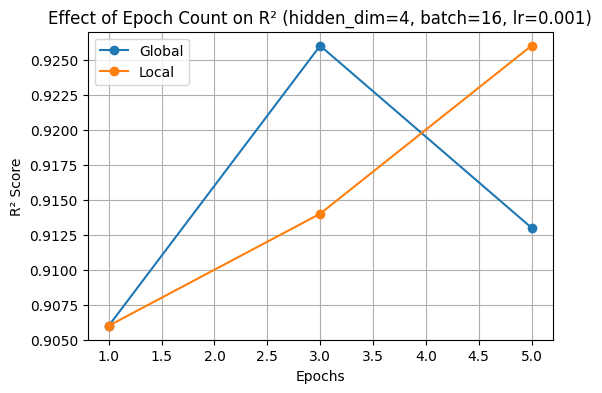

In [46]:
# Plot Epoch vs R^2
plt.figure(figsize=(6,4))
plt.plot(global_epoch.epochs, global_epoch.r2, marker="o", label="Global")
plt.plot(local_epoch.epochs, local_epoch.r2, marker="o", label="Local")

plt.xlabel("Epochs")
plt.ylabel("R² Score")
plt.title("Effect of Epoch Count on R² (hidden_dim=4, batch=16, lr=0.001)")
plt.legend()
plt.grid(True)
plt.show()

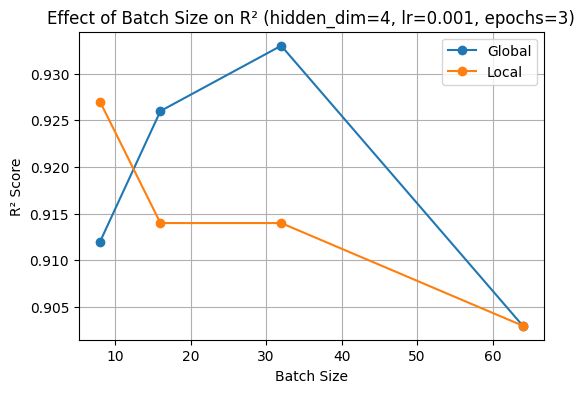

In [47]:
# Plot Batch Size vs R^2
plt.figure(figsize=(6,4))

gb = global_batch.sort_values(by="batch_size")
lb = local_batch.sort_values(by="batch_size")

plt.plot(gb.batch_size, gb.r2, marker="o", label="Global")
plt.plot(lb.batch_size, lb.r2, marker="o", label="Local")

plt.xlabel("Batch Size")
plt.ylabel("R² Score")
plt.title("Effect of Batch Size on R² (hidden_dim=4, lr=0.001, epochs=3)")
plt.legend()
plt.grid(True)
plt.show()


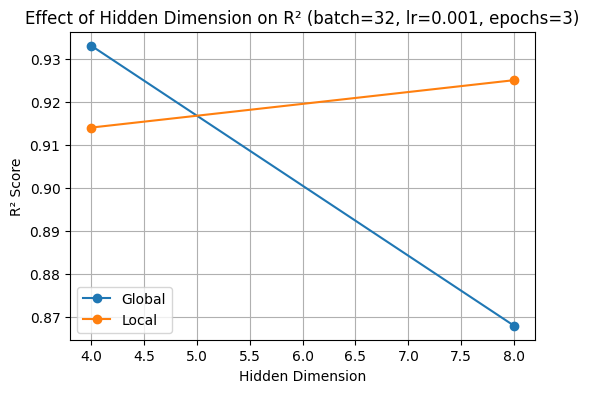

In [48]:
# Plot Hidden dimension vs R^2
plt.figure(figsize=(6,4))
plt.plot(global_hd.hidden_dim, global_hd.r2, marker="o", label="Global")
plt.plot(local_hd.hidden_dim, local_hd.r2, marker="o", label="Local")

plt.xlabel("Hidden Dimension")
plt.ylabel("R² Score")
plt.title("Effect of Hidden Dimension on R² (batch=32, lr=0.001, epochs=3)")
plt.legend()
plt.grid(True)
plt.show()


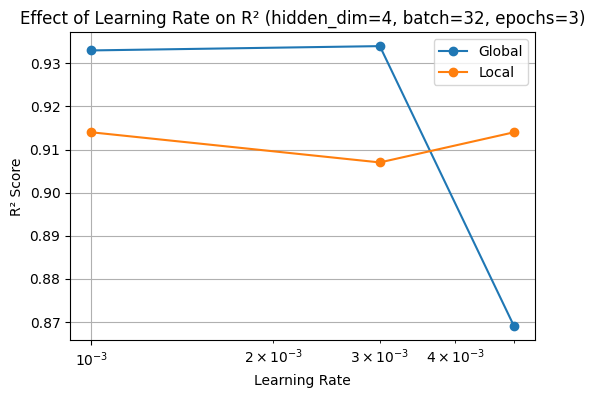

In [49]:
# Plot Learning Rate vs R^2
plt.figure(figsize=(6,4))
plt.plot(global_lr.learning_rate, global_lr.r2, marker="o", label="Global")
plt.plot(local_lr.learning_rate, local_lr.r2, marker="o", label="Local")

plt.xlabel("Learning Rate")
plt.ylabel("R² Score")
plt.title("Effect of Learning Rate on R² (hidden_dim=4, batch=32, epochs=3)")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.show()


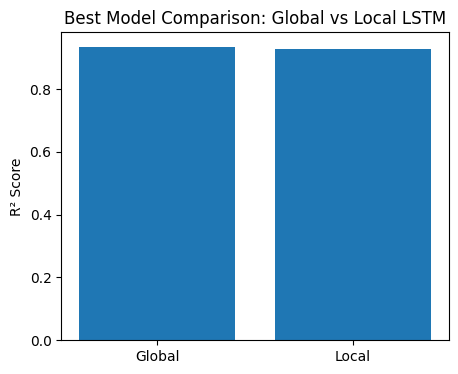

In [50]:
# Compare best Local vs best Global Model
plt.figure(figsize=(5,4))
plt.bar(best_models.model, best_models.r2)
plt.ylabel("R² Score")
plt.title("Best Model Comparison: Global vs Local LSTM")
plt.show()